In [1]:
import os
import cv2
import torch
import gdown
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import ctc_loss
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Lambda
import torch.optim as optim
from typing import List
from tqdm import tqdm

In [2]:
from utils import return_vocab_size, char_to_num, num_to_char


#### Data pipeline

In [3]:
class MyVideoDataset(Dataset):
    # TODO: Refactor this whole class
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.max_frames = 75
        self.max_alignments = 40

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        video_path = self.file_paths[idx]
        file_name = os.path.basename(video_path).split('.')[0]
        alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
        
        frames = self.load_video(video_path)
        alignments = self.load_alignments(alignment_path)
        
        return frames, alignments

    def load_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        for _ in range(min(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), self.max_frames)):
            ret, frame = cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = frame[190:236, 80:220]
            frames.append(frame)
        cap.release()

        frames = np.array(frames, dtype=np.float32)
        mean = np.mean(frames)
        std = np.std(frames)
        frames = (frames - mean) / std

        if len(frames) < self.max_frames:
            frames = np.pad(frames, [(0, self.max_frames - len(frames)), (0, 0), (0, 0)], mode='constant')
        # channel
        frames = np.expand_dims(frames, axis=-1)
        return torch.from_numpy(frames)

    def load_alignments(self, path):
        with open(path, 'r') as f:
            lines = f.readlines()
        tokens = []
        for line in lines:
            line = line.split()
            if line[2] != 'sil':
                tokens.append(line[2])

        tokens = ' '.join(tokens)
        alignment_tensor = torch.tensor([char_to_num(char) for char in tokens], dtype=torch.int64)

        if len(alignment_tensor) < self.max_alignments:
            alignment_tensor = F.pad(alignment_tensor, (0, self.max_alignments - len(alignment_tensor)), value=-1)

        return alignment_tensor

def collate_fn(batch):
    # required for padding
    frames, alignments = zip(*batch)
    
    frames = torch.stack(frames, dim=0)
    alignments = torch.stack(alignments, dim=0)

    return frames, alignments



video_files = [f'data/s1/{file}' for file in os.listdir('data/s1') if file.endswith('.mpg')]

dataset = VideoDataset(video_files)


In [4]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [5]:
frames, alignments = train_dataset[0]

In [6]:
frames.shape

torch.Size([75, 46, 140, 1])

bin green at a seven soon               


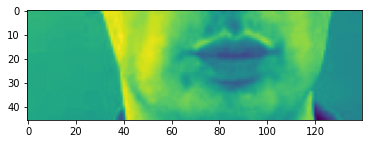

In [7]:
tensor = train_dataset[125][-1]
list_of_nums = tensor.tolist()

list_of_chars = ["".join(num_to_char(num)) for num in list_of_nums]

string_of_chars = "".join(list_of_chars)

print(string_of_chars)
plt.imshow(train_dataset[125][0][25])

#### Model

In [8]:
# TODO: Refactor this whole architecture
class Conv3DLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(Conv3DLayer, self).__init__()
        self.conv3d = nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding)
        self.activation = nn.ReLU()
        self.maxpool3d = nn.MaxPool3d((1, 2, 2))

    def forward(self, x):
        x = self.conv3d(x)
        x = self.activation(x)
        x = self.maxpool3d(x)
        return x

class TimeDistributedFlatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), x.size(1), -1)
    
class VideoModel(nn.Module):
    def __init__(self, vocab_size):
        super(VideoModel, self).__init__()
        self.conv1 = Conv3DLayer(1, 128, (3, 3, 3), padding=(1, 1, 1))
        self.conv2 = Conv3DLayer(128, 256, (3, 3, 3), padding=(1, 1, 1))
        self.conv3 = Conv3DLayer(256, 75, (3, 3, 3), padding=(1, 1, 1))
        self.flatten = TimeDistributedFlatten()
        
        lstm1_input_size = 17*5*75 
        lstm2_input_size = 256

        self.lstm1 = nn.LSTM(lstm1_input_size, 128, num_layers=1, bidirectional=True, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm2 = nn.LSTM(lstm2_input_size, 128, num_layers=1, bidirectional=True, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Linear(256, vocab_size)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        #print(f'before {x.shape}')
        x = x.view(x.size(0), 1, x.size(1), x.size(2), x.size(3))  
        x = self.conv1(x)
        #print("shape after conv1", x.shape)
        x = self.conv2(x)
        #print("shape after conv2", x.shape)

        x = self.conv3(x)
        #print("shape after conv3", x.shape)
        
        x = self.flatten(x)
        #print("shape after time-distributed flatten", x.shape)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        
        x = self.fc(x)
        x = self.softmax(x)
        return x

vocab_size = return_vocab_size() + 1

model = VideoModel(vocab_size)



In [9]:
next_data = next(iter(train_loader))

In [10]:
# vocab_size = return_vocab_size() + 1
# model = Custom3DModel(vocab_size)
outputs = model(next_data[0])

In [11]:
outputs.shape

torch.Size([2, 75, 39])

In [12]:
outputs[1].shape

torch.Size([75, 39])

In [13]:
_, indices = torch.max(outputs, 2)

In [14]:
indices

tensor([[ 1,  1,  1,  6,  6, 20,  1, 34,  6, 19, 10, 34, 10,  1, 10,  1,  4,  4,
          6, 34,  2,  1,  6, 24,  6,  6,  1,  1,  5,  6,  1, 34, 34,  1, 36, 34,
          1,  1,  1, 34, 34, 31,  1,  6, 34,  6, 15, 17,  1,  7,  6,  6,  1,  6,
         34, 20,  6, 31, 31, 34,  1, 34, 34, 34,  1,  6, 31, 34, 34,  1, 13,  6,
          1,  6, 20],
        [ 7,  1, 20,  5,  1, 20,  6,  1, 31, 19,  7,  1, 33,  6, 34,  6,  1,  6,
         20,  1,  1,  5, 17, 18, 20,  5,  6,  1,  1, 34, 34, 31, 34, 18,  7, 20,
         34, 34,  6,  6,  1,  1,  5, 31, 31,  6,  6, 31, 34,  6,  6,  1,  5,  5,
          6, 30, 30, 34, 34,  6,  1, 29, 34,  6,  6, 15,  1, 31, 31,  6,  1,  6,
          6, 31, 31]])

#### Train loop

In [17]:
vocab_size = return_vocab_size() + 1
model = VideoModel(vocab_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ctc_loss_fn = nn.CTCLoss(blank=0) 

optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, dataloader, ctc_loss_fn, optimizer, num_epochs=10):
    model.train()
    for epoch in tqdm(range(num_epochs), total=10):
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            #TODO: Fix the CTC Loss, it returns nan
            input_lengths = torch.full((inputs.size(0),), inputs.size(2), dtype=torch.long).to(device)
            target_lengths = torch.full((targets.size(0),), targets.size(1), dtype=torch.long).to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            # TODO: Fix the CTC Loss, it returns nan
            loss = ctc_loss_fn(outputs.permute(1, 0, 2), targets, input_lengths, target_lengths)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

train_model(model, train_loader, ctc_loss_fn, optimizer, num_epochs=10)

 10%|█         | 1/10 [01:51<16:44, 111.59s/it]

Epoch 1/10, Loss: nan


 10%|█         | 1/10 [02:04<18:36, 124.04s/it]


KeyboardInterrupt: 